<a href="https://colab.research.google.com/github/talmolab/sleap/blob/main/docs/notebooks/Analysis_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis examples

In this notebook we'll show examples of how you might use the predictions exported from SLEAP. We'll work with an [Analysis HDF5](https://sleap.ai/tutorials/analysis.html) file (rather than the `.slp` predictions file). This HDF5 file can be exported from SLEAP.

We advise building your post-SLEAP analysis pipeline around these HDF5 files rather than trying to work directly with the `.slp` files used by SLEAP.

**Note**: You can work with these HDF5 directly in Python (as we'll do here) or MATLAB without having SLEAP itself installed.

## Example analysis data

Let's start by download a sample HDF5. These predictions were created with models trained on our [sample Drosophila melanogaster courtship dataset](https://github.com/talmolab/sleap-datasets). Using these models we can inference on a video clip with 3000 frames. The video clip, resulting predictions, and exported HDF5 are all available [here](https://github.com/talmolab/sleap/tree/main/docs/notebooks/analysis_example).

We'll just download the `predictions.analysis.h5` file:

We can set the path and filename to the analysis HDF5. In our case, this is just `predictions.analysis.h5`. If you're running analysis code on your local computer this will be the full path and filename of your HDF5. If you're running analysis code on Colab, then you'll probably copy files to Colab via Google Drive and should use the path to your file there.

In [1]:
filename = "./10-03-22_Test_34_5-1v5-4.mp4.predictions.fixed_id.000_10-03-22_Test_34_5-1v5-4.analysis.h5.h"

## Loading the data

We use the [h5py](https://www.h5py.org) package to load data from the HDF5. This is already installed in Colab. If your running analysis code on your local machine and have SLEAP installed, then `h5py` and other packages we use are already installed in your SLEAP conda environment. Otherwise, you may need to use `conda` or `pip` to install `h5py` as well as `numpy`, `scipy`, `matplotlib`, `seaborn`, and any other packages you want use in your analysis code.

Let's load the file and take a peek.

In [2]:
import h5py
import numpy as np

with h5py.File(filename, "r") as f:
    dset_names = list(f.keys())
    locations = f["tracks"][:].T
    node_names = [n.decode() for n in f["node_names"][:]]

print("===filename===")
print(filename)
print()

print("===HDF5 datasets===")
print(dset_names)
print()

print("===locations data shape===")
print(locations.shape)
print()

print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()


===filename===
./10-03-22_Test_34_5-1v5-4.mp4.predictions.fixed_id.000_10-03-22_Test_34_5-1v5-4.analysis.h5.h

===HDF5 datasets===
['edge_inds', 'edge_names', 'instance_scores', 'labels_path', 'node_names', 'point_scores', 'provenance', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks', 'video_ind', 'video_path']

===locations data shape===
(55649, 6, 2, 2)

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In our example file, the shape of the locations matrix (the `tracks` dataset) is (3000, 13, 2, 2) **after it is transposed** (with the `.T`). We transpose the data when loading it in Python; no transpose is needed when using MATLAB. This is because Python and MATLAB expect matrices to be stored differently.

Here's what each dimension of the matrix means:

- 3000: the number of frames;

- 13: the number of nodes in the skeleton (we've also loaded and displayed the `node_names` dataset with the names of these 13 nodes);

- 2: for the x and y coordinates;

- 2: the number of distinct animal identities which were found (we have 2 flies in the video clip and they were tracked perfectly, so we ended up with exactly 2 track, but there may be more tracks than animals if tracking didn't work as well).

We can get these counts from the shape of the matrix, like so:


In [3]:
frame_count, node_count, _, instance_count = locations.shape

print("frame count:", frame_count)
print("node count:", node_count)
print("instance count:", instance_count)

frame count: 55649
node count: 6
instance count: 2


Now that we've loaded the data, let's see some different things we can do with it...

## Fill missing values

In [4]:
from scipy.interpolate import interp1d

def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

In [5]:
locations = fill_missing(locations)

## Visualize thorax movement across video

- Slice of a given frame for both animals

In [33]:
locations[0]

array([[[439.7230835 , 688.24554443],
        [712.0670166 , 203.99502563]],

       [[415.9536438 , 692.01403809],
        [675.902771  , 232.02056885]],

       [[403.55664062, 704.00512695],
        [727.99639893, 203.92848206]],

       [[536.26092529, 592.37579346],
        [591.46343994, 220.29003906]],

       [[475.8515625 , 640.25811768],
        [639.99786377, 216.42446899]],

       [[411.95632935, 699.69329834],
        [715.59655762, 212.29585266]]])

- Slice of a given body part for both animals

In [34]:
locations[0][0]

array([[439.7230835 , 688.24554443],
       [712.0670166 , 203.99502563]])

- Slice of one coordinate of a given body part for both animal (X coordinates)

In [35]:
locations[0][0][0]

array([439.7230835 , 688.24554443])

- Slice of one coordinate of a given body part for one animal (X coordinates)

In [36]:
locations[0][0][0][0]

439.72308349609375

In [22]:
print("===nodes===")
for i, name in enumerate(node_names):
    print(f"{i}: {name}")
print()

===nodes===
0: left_ear
1: right_ear
2: nose
3: tail_base
4: thorax
5: forehead



In [23]:
HEAD_INDEX = 1
THORAX_INDEX = 3
ABDO_INDEX = 4

head_loc = locations[:, HEAD_INDEX, :, :]
thorax_loc = locations[:, THORAX_INDEX, :, :]
abdo_loc = locations[:, ABDO_INDEX, :, :]

In [24]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [25]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Thorax tracks')

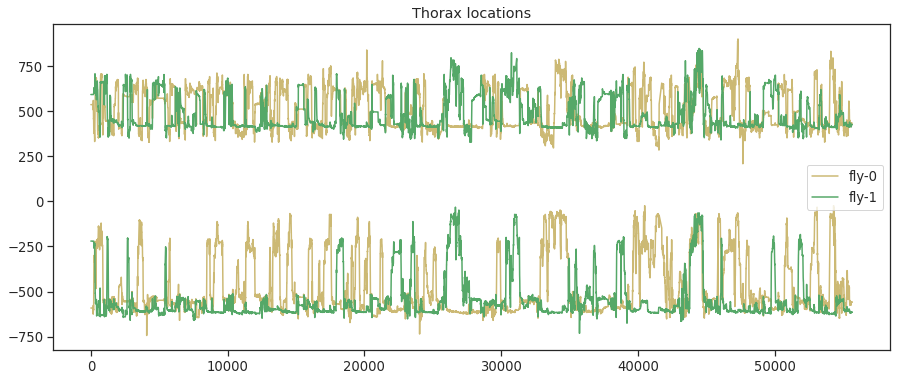

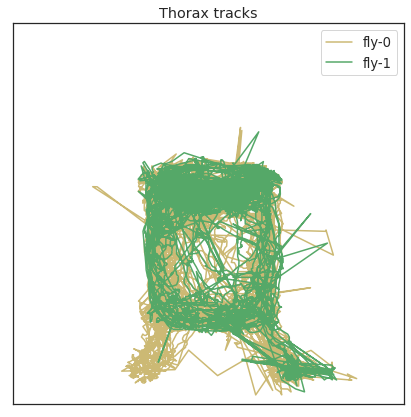

In [26]:
plt.figure()
plt.plot(thorax_loc[:,0,0], 'y',label='fly-0')
plt.plot(thorax_loc[:,0,1], 'g',label='fly-1')

plt.plot(-1*thorax_loc[:,1,0], 'y')
plt.plot(-1*thorax_loc[:,1,1], 'g')

plt.legend(loc="center right")
plt.title('Thorax locations')


plt.figure(figsize=(7,7))
plt.plot(thorax_loc[:,0,0],thorax_loc[:,1,0], 'y',label='fly-0')
plt.plot(thorax_loc[:,0,1],thorax_loc[:,1,1], 'g',label='fly-1')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Thorax tracks')

## More advanced visualizations

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [27]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two flies. Let's get results for each separately.

In [28]:
thx_vel_fly0 = smooth_diff(thorax_loc[:, :, 0])
thx_vel_fly1 = smooth_diff(thorax_loc[:, :, 1])

### Visualizing thorax x-y dynamics and velocity for fly 0

Text(0.5, 1.0, 'Velocity')

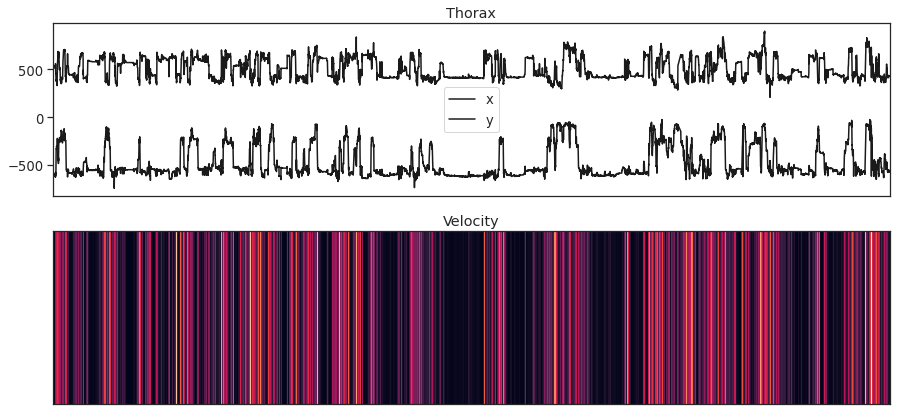

In [29]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.imshow(thx_vel_fly0[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of fly speed

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of fly speed')

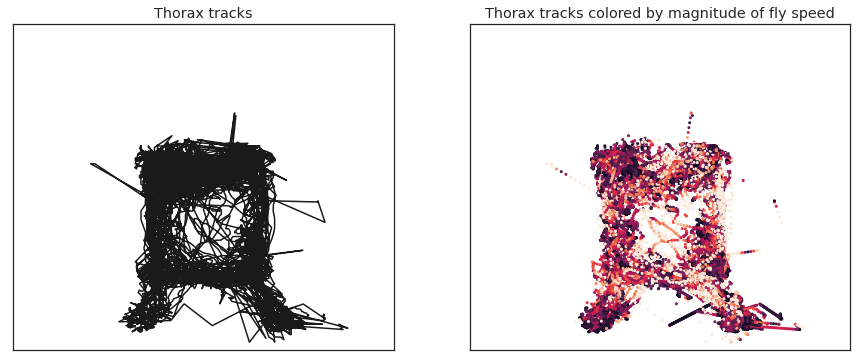

In [30]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_fly0  # use thx_vel_fly1 for other fly
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of fly speed')

### Find covariance in thorax velocities between fly-0 and fly-1

In [14]:
import pandas as pd

def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

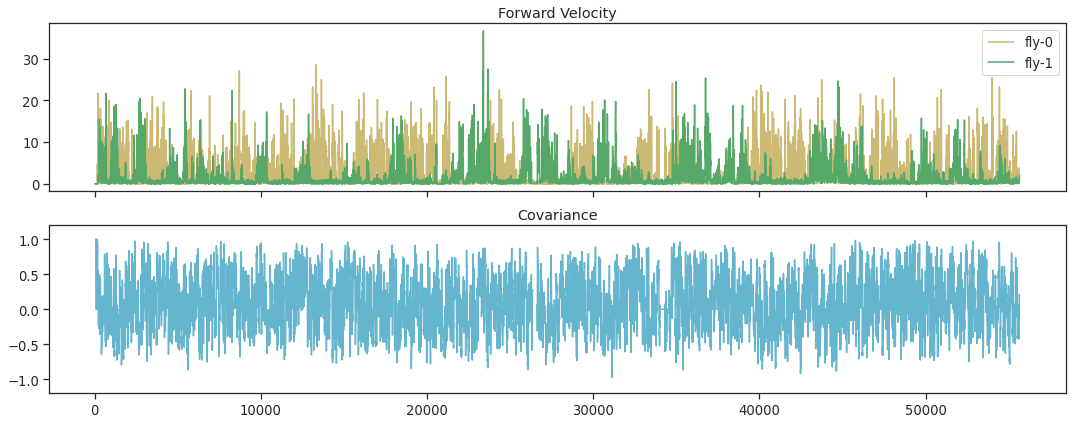

In [15]:
win = 50

cov_vel = corr_roll(thx_vel_fly0, thx_vel_fly1,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_fly0, 'y', label='fly-0')
ax[0].plot(thx_vel_fly1, 'g', label='fly-1')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run simple k-means on the velocities from each frame.


In [16]:
def instance_node_velocities(instance_idx):
    fly_node_locations = locations[:, :, :, instance_idx]
    fly_node_velocities = np.zeros((frame_count, node_count))

    for n in range(0, node_count):
        fly_node_velocities[:, n] = smooth_diff(fly_node_locations[:, n, :])
    
    return fly_node_velocities

In [17]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(node_count), node_names, rotation=20);
    plt.title(f'Fly {instance_idx} node velocities')

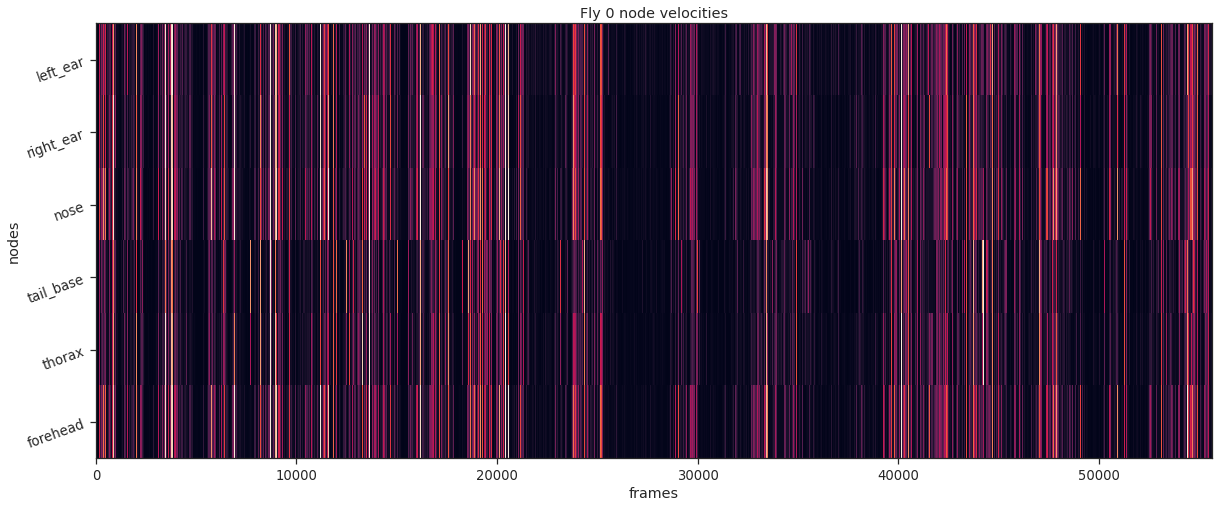

In [18]:
fly_ID = 0
fly_node_velocities = instance_node_velocities(fly_ID)
plot_instance_node_velocities(fly_ID, fly_node_velocities)

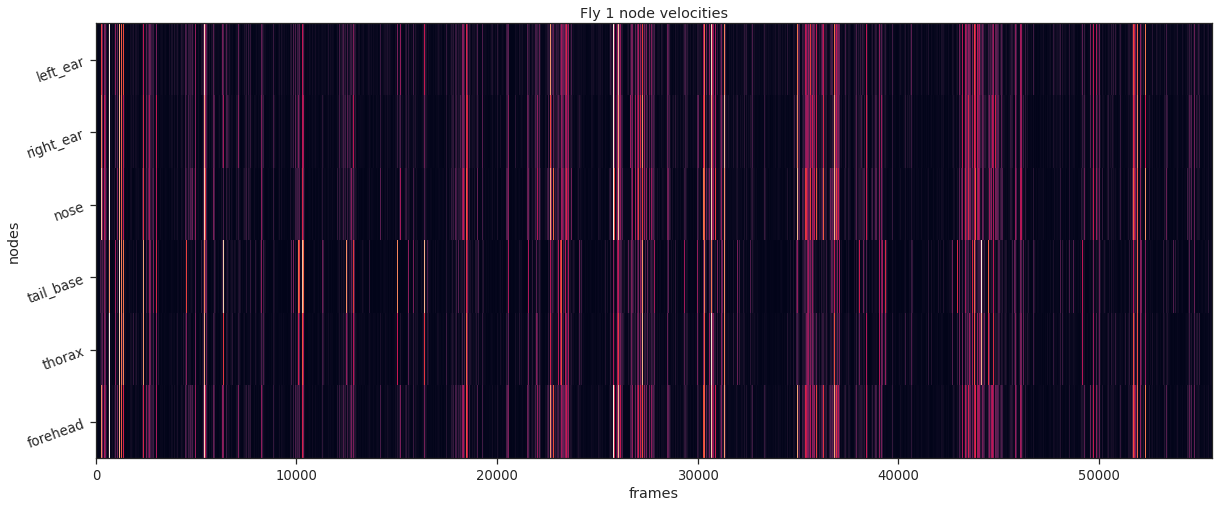

In [19]:
fly_ID = 1
fly_node_velocities = instance_node_velocities(fly_ID)
plot_instance_node_velocities(fly_ID, fly_node_velocities)

In [20]:
from sklearn.cluster import KMeans

ModuleNotFoundError: No module named 'sklearn'

In [21]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(fly_node_velocities)

NameError: name 'KMeans' is not defined

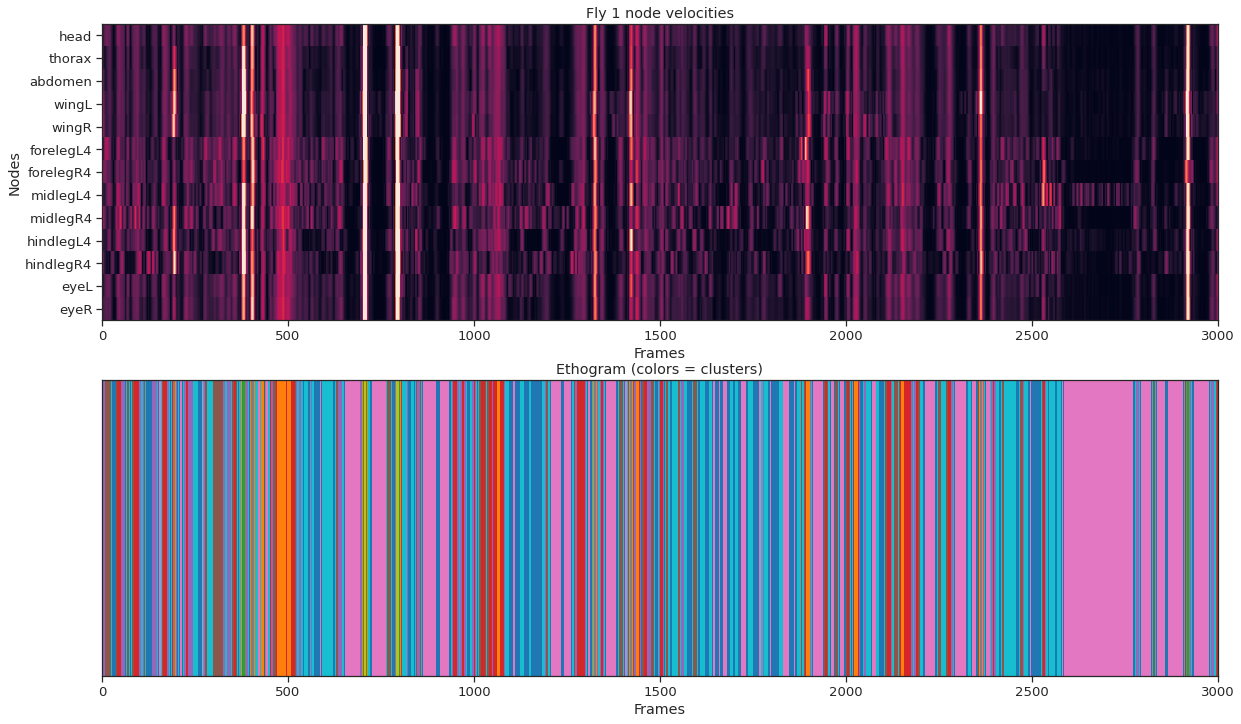

In [23]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(fly_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(node_count))
ax1.set_yticklabels(node_names);
ax1.set_title(f"Fly {fly_ID} node velocities")
ax1.set_xlim(0,frame_count)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");